In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import scanpy as sc
import pandas as pd
import newick
from Bio import Phylo
from anndata import AnnData
import ete3
from scipy.sparse import issparse

In [3]:
import ot
import lineageot
import lineageot.evaluation as sim_eval
import lineageot.inference as sim_inf
import lineageot.simulation as sim
from lineageot.inference import barcode_distances

from jax import numpy as jnp
from moscot import FusedGW
import ott
import matplotlib.pyplot as plt
from copy import deepcopy
import networkx as nx
import seaborn as sns
import numpy as np

In [4]:
root = "output_f"
# root = "output"

In [5]:
edges = pd.read_csv(f"./{root}/edges.csv", index_col=0)
states_full = pd.read_csv(f"./{root}/states_full.csv", index_col=0)

In [6]:
tree = newick.read(f"./{root}/tree_gt_bin_tedsim_pd0.newick")[0]

In [7]:
# taken from cassiopeia
def to_newick(tree: nx.DiGraph, record_branch_lengths: bool = False) -> str:
    """Converts a networkx graph to a newick string.

    Args:
        tree: A networkx tree
        record_branch_lengths: Whether to record branch lengths on the tree in
            the newick string

    Returns:
        A newick string representing the topology of the tree
    """

    def _to_newick_str(g, node):
        is_leaf = g.out_degree(node) == 0
        weight_string = ""

        if record_branch_lengths and g.in_degree(node) > 0:
            parent = list(g.predecessors(node))[0]
            weight_string = ":" + str(g[parent][node]["length"])

        _name = str(node)
        return (
            "%s" % (_name,) + weight_string
            if is_leaf
            else (
                "("
                + ",".join(
                    _to_newick_str(g, child) for child in g.successors(node)
                )
                + ")"
                + weight_string
            )
        )

    root = [node for node in tree if tree.in_degree(node) == 0][0]
    return _to_newick_str(tree, root) + ";"


def ete3_to_networkx(adata: AnnData, tree: ete3.Tree) -> nx.DiGraph:
    """Converts an ete3 Tree to a networkx DiGraph.

    Args:
        tree: an ete3 Tree object

    Returns:
        a networkx DiGraph
    """

    g = nx.DiGraph()
    internal_node_iter = -1
    
    for n in tree.traverse():
        if n.is_root():
            n.name = "root"
            break    
    
    for n in tree.traverse():
        if n.is_root():
            continue
        if n.name == "":
            n.name = internal_node_iter
            internal_node_iter -= 1
        elif n.name.startswith("t"):
            names = [i for i, name in enumerate(adata.obs_names) if f"t{name}" == n.name]
            assert len(names) == 1, names
            n.name = names[0]

        g.add_edge(n.up.name, n.name)
        
    for n in g.nodes:
        if n == 'root':
            assert g.in_degree(n) == 0, (n, g.in_degree(n))
        else:
            assert g.in_degree(n) == 1, (n, g.in_degree(n))

    return g


def prune_tree(adata, tree: newick.Node, depth: int, remove: bool = True) -> newick.Node:
    tree = deepcopy(tree)
    if depth is None:
        return adata.copy(), tree
    adata = adata[adata.obs[depth_key] == depth].copy()
    names = [f"t{i}" for i in adata.obs_names]
    print(f"Keeping {len(names)} nodes")
    tree.prune_by_names(names, inverse=True)
    if remove:
        return adata, remove_redundant(tree, keep_leaf_name=True)
    
    return adata, tree

def remove_redundant(tree: newick.Node, **kwargs) -> newick.Node:
    tree.remove_redundant_nodes(**kwargs)
    return tree

def print_tree(tree: newick.Node):
    print(tree.ascii_art())

In [8]:
def _internal_nodes_fixed(tree):
    """
    Returns a list of the non-leaf nodes of a tree
    """
    nodes = [node for node in tree if tree.degree(node) >= 2]
    nodes.sort(key=lambda n: np.inf if n == 'root' else int(n))
    if nodes[-1] == 'root':
        nodes = nodes[:-1]
    return nodes


# monkeypatched because our tree has 'root' somehow inside and it's problematic with the sort
sim_inf.get_internal_nodes = _internal_nodes_fixed


def create_cell(adata: AnnData, *, ix=None, cell_id=None, key=None):
    """
    Create LineageOT cell based on index or cell ID.
    
    adata: Annotated data object.
    ix: Index
    cell_id: Cell ID. Only one of `ix` or `cell_id` can be supplied.
    key: Key in `adata.obsm` from where to get the features. If `None`, use X.
    """
    assert sum([ix is not None, cell_id is not None]) == 1, "Only 1 of `ix` or `cell_id` must be speciied"
    if ix is not None:
        ix = int(ix)
        data = adata.X[ix] if key is None else adata.obsm[key][ix]
        bc = adata.obsm['barcodes'][ix].copy()
        metadata = adata.obs.iloc[ix].to_dict()
    else:
        cell_id = str(cell_id)
        bdata = adata[cell_id].copy()
        data = bdata.X if key is None else bdata.obsm[key]
        data = data[0]
        bc = bdata.obsm['barcodes'][0]
        metadata = bdata.obs.iloc[0].to_dict()
        
    if issparse(data):
        data = data.A
    
    return sim.Cell(data, bc), metadata


def annotate_inner_nodes(G: nx.DiGraph) -> nx.DiGraph:
    """
    Correctly annotate inner tree nodes
    
    G: Lineage tree.
    """
    G = G.copy()
    leaves = sim_inf.get_leaves(G, include_root=False)
    queue = leaves[:]
    
    while queue:
        ix = queue[0]
        queue = queue[1:]
        assert G.in_degree(ix) == 1, (ix, G.in_edges(ix))
        (parent_node_ix, _ix), = G.in_edges(ix)
        assert _ix == ix, (_ix, ix)
        if isinstance(parent_node_ix, str) or parent_node_ix >= 0:
            continue

        cell_id = G.nodes[ix]['cellID']
        parent = str(edges.loc[int(cell_id)]['V1'])
        if parent in G.nodes:
            continue
        G = nx.relabel_nodes(G, {parent_node_ix: parent})
        
        assert 'cell' not in G.nodes[parent], G.nodes[parent]
        try:
            cell, metadata = create_cell(adata_observed, cell_id=parent, key='X_pca_30')
            G.nodes[parent]['cell'] = cell
            for k, v in metadata.items():
                G.nodes[parent][k] = v
        except KeyError as e:
            assert parent in str(e)
            G.nodes[parent]['cellID'] = int(parent)
            # unobserved internal state
            
        queue.append(parent)
        
    for n in G.nodes:
        if isinstance(n, str):
            try:
                n = int(n)
                assert n > 0, n
            except ValueError:
                assert n == 'root', n
        else:
            assert n >= 0, n
    
    leaves_new = sim_inf.get_leaves(G, include_root=False)
    assert sorted(leaves) == sorted(leaves_new)
    
    return G

def add_times(adata: AnnData, G: nx.DiGraph, tp, *, rate_estimate=None, method='least_squares') -> nx.DiGraph:
    """
    Add time information to nodes/edges, as done in LineageOT.
    """
    G = deepcopy(G)
    sim_inf.add_leaf_times(G, tp)
    
    if rate_estimate is None:
        rate_estimate = sim_inf.rate_estimator(adata.obsm['barcodes'], tp)
    sim_inf.annotate_tree(
        G, rate_estimate * np.ones(adata.obsm['barcodes'].shape[1]),
        time_inference_method = method, overwrite_times=True
    );
    return G


def validate(adata, G, key=None, adata_full=None):
    """
    Validate that the truee tree is correctly constructed.
    
    adata: Subsetted annotated data object.
    G: Tree for the later time point.
    key: Key in `adata.obsm` from where to get the features. If `None`, use X.
    adata_full: AnnData containing not-observed RNA.
    """
    for i in G.nodes:
        n = G.nodes[i]
        if isinstance(i, int):
            data = adata.X[i] if key is None else adata.obsm[key][i]
            bc = adata.obsm['barcodes'][i]
            np.testing.assert_array_equal(n['cell'].x, data)
            np.testing.assert_array_equal(n['cell'].barcode, bc)
            for k in ['parent', 'cluster', 'depth', 'cellID']:
                assert n[k] == adata.obs[k].iloc[i], adata.obs
            
            assert n['cellID'] == adata.obs.iloc[i]['cellID'], (n['cellID'], adata.obs.iloc[i]['cellID'])
        elif isinstance(i, str) and i != "root" and adata_full is not None:
            bdata = adata_full[i]
            data = bdata.X[0] if key is None else bdata.obsm[key][0]
            bc = bdata.obsm['barcodes'][0]
            np.testing.assert_array_equal(n['cell'].x, data)
            np.testing.assert_array_equal(n['cell'].barcode, bc)
            for k in ['parent', 'cluster', 'depth', 'cellID']:
                assert n[k] == bdata.obs[k].iloc[0], adata.obs
            
            assert n['cellID'] == int(bdata.obs_names[0]), n['cellID']
        assert 'time_to_parent' in n, n
    for e in G.edges:
        assert 'time' in G.edges[e].keys(), e
        


def construct_gt_tree(adata: AnnData, tree: newick.Node, *, depth: int, key=None, **kwargs):
    """
    Construct GT tree for LineageOT
    
    adata: Annotated data object.
    tree: Lineage tree from simulation.
    depth: Depth
    remove: Remove useless nodes.
    key: Key in `adata.obsm` from where to get the features. If `None`, use X.
    """
    bdata, tree = prune_tree(adata, tree, depth=depth, remove=True)
    G = ete3_to_networkx(bdata, ete3.Tree(newick.dumps(tree), 1))
    for n in G.nodes:
        assert isinstance(n, int) or n == 'root', n
        try:
            if n == 'root':
                G.nodes[n]['time_to_parent'] = 0
                G.nodes[n]['cell'] = sim.Cell(np.nan, np.zeros(adata.obsm['barcodes'].shape[1]))
                continue
            # TODO: from sim
            # G.nodes[n]['time_to_parent'] = depth
            if n < 0:
                raise IndexError(n)
            cell, metadata = create_cell(bdata, ix=n, key=key)
            G.nodes[n]['cell'] = cell
            for k, v in metadata.items():
                G.nodes[n][k] = v
        except IndexError as e:
            pass
            # print(e)
    for e in G.edges:
        # TODO: from sim
        pass
        # G.edges[e]['time'] = np.nan
      
    # add the times
    G = annotate_inner_nodes(G)
    if depth is not None:
        G = add_times(bdata, G, depth, **kwargs)
        
    return bdata, G


def add_node_depths(adata: AnnData, G: nx.DiGraph):
    if 'node_depth' in adata.obs:
        adata.obs.pop("node_depth")
    G.nodes['root']['node_depth'] = 0
    depths = {}
    for n in nx.dfs_preorder_nodes(G, 'root'):
        try:
            (parent, _), = G.in_edges(n)
            G.nodes[n]['node_depth'] = G.nodes[parent]['node_depth'] + 1
        except ValueError as e:
            assert "not enough values to unpack" in str(e)
        try:
            depths[str(G.nodes[n]['cellID'])] = G.nodes[n]['node_depth']
        except KeyError:
            assert n == "root"
    depths = pd.Series(depths, name='node_depth')
    adata.obs = adata.obs.merge(depths, left_index=True, right_index=True, how='left')
    

def cut_tree_at_depth(G: nx.DiGraph, depth):
    G_new = deepcopy(G)
    fst_n, snd_n = [], ["synroot"]
    synthetic_root = G_new.add_node("synroot", **deepcopy(G.nodes['root']))
    for n in nx.breadth_first_search.bfs_tree(G, 'root'):
        nd = G.nodes[n]['node_depth']
        if nd < depth:
            fst_n.append(n)
        else:
            snd_n.append(n)
        if nd == depth:
            (parent, _), = G.in_edges(n)
            G_new.remove_edge(parent, n)
            G_new.add_edge("synroot", n)
    
    top = nx.subgraph(G_new, fst_n)
    bottom = nx.subgraph(G_new, snd_n)
    bottom = nx.relabel_nodes(bottom, {"synroot": "root"})
    return top, bottom


def get_true_coupling(G_t, G):
    num_cells_early = len(sim_inf.get_leaves(G_t)) - 1
    num_cells_late = len(sim_inf.get_leaves(G)) - 1
    
    coupling = np.zeros([num_cells_early, num_cells_late])
    
    cells_early = sim_inf.get_leaves(G_t, include_root = False)
    
    for i, cell in enumerate(cells_early):
        descendants = sim_inf.get_leaf_descendants(G, cell)
        coupling[i, descendants] = 1/(num_cells_early*len(descendants))
        
    return pd.DataFrame(coupling, index=cells_early, columns=list(map(str, range(1, num_cells_late + 1))))

In [9]:
adata = AnnData(X=pd.read_csv(f"./{root}/counts_tedsim_pa0.75_step0.25.csv").T.values,
                obs=pd.read_csv(f"./{root}/cell_meta_tedsim_pa0.75_step0.25.csv", index_col=0),
                obsm={"barcodes": pd.read_csv(f"./{root}/character_matrix_pd0.txt", sep=" ").values})
bcs = adata.obsm['barcodes']
if not np.issubdtype(bcs.dtype, int):
    bcs[bcs == '-'] = -1
    bcs = bcs.astype(int)
    adata.obsm['barcodes'] = bcs
adata.obs['cluster'] = adata.obs['cluster'].astype("category")
adata.obs['depth'] = adata.obs['depth'].astype(int)
adata.obs['parent'] = adata.obs['parent'].astype("category")

/home/michal/.miniconda3/envs/cellrank/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [10]:
adata_observed = adata.copy()

In [11]:
sc.pp.normalize_total(adata_observed, target_sum=1e4)
sc.pp.log1p(adata_observed)
sc.pp.highly_variable_genes(adata_observed)
sc.tl.pca(adata_observed, use_highly_variable=False)
sc.pp.neighbors(adata_observed, n_pcs=30)
sc.tl.umap(adata_observed)
adata_observed.obsm['X_pca_30'] = adata_observed.obsm['X_pca'][:, :30].copy()

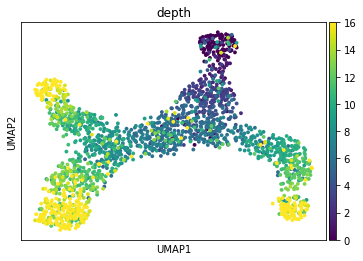

In [12]:
sc.pl.umap(adata_observed, color='depth')

In [13]:
epsilon = 1e-2
state_key = 'X_pca_30'
depth_key = 'node_depth'
rate_estimate = 0.11
early_tp = 6
late_tp = 10

In [14]:
bdata, G = construct_gt_tree(adata_observed, tree, depth=None, key=state_key, rate_estimate=rate_estimate,
                             method='least_squares')
add_node_depths(adata_observed, G)
adata_observed.obs['node_depth'].value_counts()

10    1024
9      512
8      256
7      128
6       64
5       32
4       16
3        8
2        4
1        2
Name: node_depth, dtype: int64

In [15]:
eadata = adata_observed[adata_observed.obs[depth_key] == early_tp].copy()
ladata = adata_observed[adata_observed.obs[depth_key] == late_tp].copy()

In [16]:
T = lineageot.fit_tree(ladata, late_tp)

     pcost       dcost       gap    pres   dres
 0: -5.1753e+04 -5.3337e+04  1e+04  2e-01  3e-01
 1: -5.1703e+04 -5.4570e+04  5e+03  7e-02  9e-02
 2: -5.1587e+04 -5.3093e+04  2e+03  1e-02  2e-02
 3: -5.1793e+04 -5.2248e+04  5e+02  3e-03  4e-03
 4: -5.1806e+04 -5.2207e+04  4e+02  2e-03  2e-03
 5: -5.1858e+04 -5.2066e+04  2e+02  8e-04  1e-03
 6: -5.1875e+04 -5.2014e+04  1e+02  1e-16  2e-16
 7: -5.1903e+04 -5.1933e+04  3e+01  1e-16  2e-16
 8: -5.1909e+04 -5.1916e+04  7e+00  1e-16  2e-16
 9: -5.1911e+04 -5.1911e+04  3e-01  1e-16  2e-16
10: -5.1911e+04 -5.1911e+04  9e-03  1e-16  2e-16
Optimal solution found.


<AxesSubplot:>

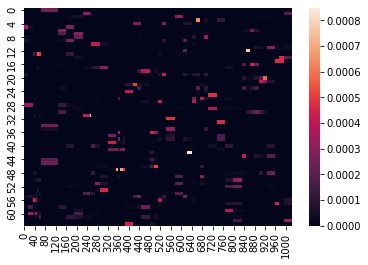

In [17]:
# TODO: debug
coupling = lineageot.fit_lineage_coupling(adata_observed, early_tp, late_tp, T,
                                          time_key=depth_key, epsilon=epsilon,
                                          state_key=state_key).X
sns.heatmap(coupling)

In [18]:
bcde = barcode_distances(eadata.obsm['barcodes'])
bcdl = barcode_distances(ladata.obsm['barcodes'])
rnad = ot.utils.dist(eadata.obsm[state_key], ladata.obsm[state_key])
bcde /= bcde.max()
bcdl /= bcdl.max()
rnad /= rnad.max()

bcde_g = ott.geometry.geometry.Geometry(cost_matrix=jnp.asarray(bcde))
bcdl_g = ott.geometry.geometry.Geometry(cost_matrix=jnp.asarray(bcdl))
rnad_g = ott.geometry.geometry.Geometry(cost_matrix=jnp.asarray(rnad))

In [19]:
fgw = FusedGW(epsilon=epsilon, alpha=0.75)

<AxesSubplot:>

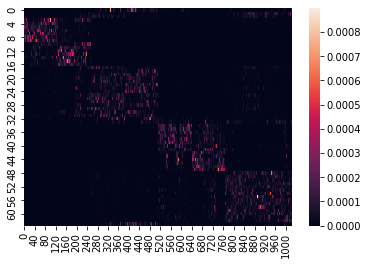

In [20]:
fgw.fit(bcde_g, bcdl_g, rnad_g, max_iterations=100, verbose=False)
sns.heatmap(fgw.matrix)

In [25]:
bdata, G2 = construct_gt_tree(adata_observed, tree, depth=late_tp, key=state_key, rate_estimate=rate_estimate,
                              method='least_squares')
add_node_depths(bdata, G2)
validate(bdata, G2, key=state_key)

Keeping 1024 nodes
     pcost       dcost       gap    pres   dres
 0: -1.8547e+04 -3.1546e+04  3e+04  4e-01  4e-01
 1: -2.2113e+04 -3.6533e+04  3e+04  3e-01  3e-01
 2: -2.3309e+04 -3.5833e+04  2e+04  2e-01  2e-01
 3: -2.3176e+04 -3.0806e+04  1e+04  1e-01  1e-01
 4: -2.1936e+04 -2.4370e+04  3e+03  2e-02  2e-02
 5: -2.1582e+04 -2.1712e+04  2e+02  8e-04  8e-04
 6: -2.1585e+04 -2.1589e+04  4e+00  2e-05  2e-05
 7: -2.1585e+04 -2.1585e+04  9e-02  3e-07  3e-07
 8: -2.1585e+04 -2.1585e+04  1e-03  3e-09  3e-09
Optimal solution found.


<AxesSubplot:>

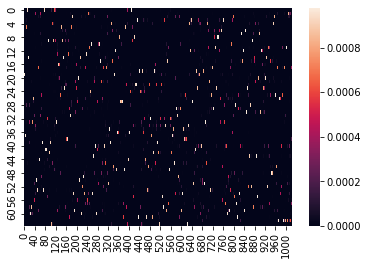

In [22]:
# TODO: debug
coupling = lineageot.fit_lineage_coupling(adata_observed, early_tp, late_tp, G2,
                                          time_key=depth_key, epsilon=epsilon,
                                          state_key=state_key)
sns.heatmap(coupling.X)

In [28]:
G_t, G_b = cut_tree_at_depth(G2, 7)
print(len(sim_inf.get_leaves(G_t, include_root=False)))
true_coupling = get_true_coupling(G_t, G2)
true_coupling = true_coupling.loc[coupling.obs_names, :].loc[:, coupling.var_names]

64


<AxesSubplot:>

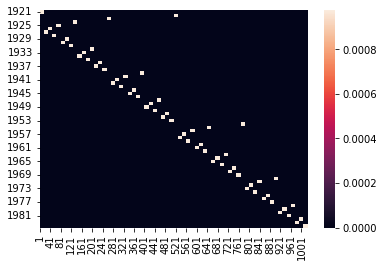

In [29]:
sns.heatmap(true_coupling)

In [ ]:
# TODO: ancestor/descendant errors